In [1]:
from ngsolve import *
from ngsolve.webgui import Draw


import numpy as np
import matplotlib.pyplot as plt

from newtonmethod import NewtonWithLinesearch
SetNumThreads(4)

import netgen.occ as ngocc
from netgen.meshing import MeshingParameters
from netgen.webgui import Draw as DrawGeo

## Plate with hole example
Plane-strain approach to the example from Rank and Düster (2001).

A quarter of the square plate with circular, central hole is meshed. We use second order elements.

In [2]:
rect = ngocc.WorkPlane().Rectangle(100,100).Face()
circ = ngocc.WorkPlane().Circle(0,0,10).Face()
circ.maxh=2
plate = rect-circ

plate.edges.Max(ngocc.X).name = "force"
plate.edges.Min(ngocc.X).name = "symx"
plate.edges.Min(ngocc.Y).name = "symy"

geo = ngocc.OCCGeometry(plate, dim=2)

mesh = Mesh(geo.GenerateMesh(MeshingParameters(maxh=10, grading=0.1)))

order = 2
mesh.Curve(order)
Draw(mesh)

WebGuiWidget(value={'gui_settings': {}, 'ngsolve_version': '6.2.2402-40-g3ac4c9abc', 'mesh_dim': 2, 'order2d':…

BaseWebGuiScene

Material parameters

In [3]:
# Young's modulus
Emod = 206900

# Poisson's ratio
nu = 0.29

lam = Emod*nu/(1+nu)/(1-2*nu)
mu = Emod/2/(1+nu)

# Hardening parameter
H = 1.
nu_H = 0.5
mu_H = H/2/(1+nu_H)

# Yield stress
sigma_Y = 450

loadpar = Parameter(0)

The finite element spaces for the approach with dissipation function. We use displacements $\boldsymbol{u}$ vectorvalued $H^1$ and plastic variables $\alpha_i$ in $L^2$. Three plastic components define the symmetric plastic strain tensor.

In [4]:
fespace_u = VectorH1(mesh, order=order, dirichletx="symx", dirichlety="symy", dirichletz="symz")
fespace_alpha = L2(mesh, order=order-1)**3

fespace = fespace_u * fespace_alpha

q = GridFunction(fespace)
u, alpha = q.components

q0 = GridFunction(fespace)
u0, alpha0 = q0.components

def strain_p(alpha):
    return CoefficientFunction((alpha[0], alpha[2], 0,
                                 alpha[2], alpha[1], 0,
                                 0, 0, -alpha[0] - alpha[1]), dims=(3,3))

A regularization of the norm, for the regularized dissipation function

In [5]:
def NormReg(p, rho=1e-6):
    return sqrt(InnerProduct(p,p)+rho**2)

Define the problem symbolically, including energies, external force and dissipation

In [6]:
u_, alpha_ = fespace.TrialFunction()

gradu_ = Sym(Grad(u_))
strain_ = CoefficientFunction((gradu_[0], gradu_[1], 0,
                               gradu_[2], gradu_[3], 0,
                               0, 0, 0), dims=(3,3))


strain_el_ = strain_ - strain_p(alpha_)

psi_el = mu*InnerProduct(strain_el_,strain_el_) + lam/2*Trace(strain_el_)**2

psi_p = mu_H*InnerProduct(strain_p(alpha_), strain_p(alpha_))

strain_p_dot_ = strain_p(alpha_) - strain_p(alpha0)


a = BilinearForm(fespace, eliminate_internal=True)
a += SymbolicEnergy(psi_el + psi_p)
a += SymbolicEnergy( sqrt(2/3)*sigma_Y*NormReg(strain_p_dot_), bonus_intorder=-2)
a += SymbolicEnergy(-loadpar*u_[0], definedon=mesh.Boundaries("force"))

In [7]:
q.vec[:] = 0
q0.vec[:] = 0

flist = [0]
ulist = [0]
helpvec = q0.vec.CreateVector()

maxforce = 400 # 500 # 511
for l in np.linspace(0,maxforce,21)[1:]:
    print(f"force {l}:")
    
    helpvec.data = q.vec - q0.vec
    q0.vec.data = q.vec
    q.vec.data += helpvec

    loadpar.Set(l)
    err, nit = NewtonWithLinesearch(a, q.vec)
    if err: break

    flist.append(l)
    ux_mean = Integrate(u[0], mesh, definedon=mesh.Boundaries("force"))
    ulist.append(ux_mean)

force 20.0:
initial residual 618.6903731090177
newton step  1  res  7.69016174877575 damping 1
newton step  2  res  5.557279874873557e-05 damping 1
newtonsteps:  2 , res  5.557279874873557e-05  <  1e-06 * 618.6903731090177
force 40.0:
initial residual 9533.292874869987
newton step  1  res  30.738901132809783 damping 1
newton step  2  res  0.0018151172954786353 damping 1
newtonsteps:  2 , res  0.0018151172954786353  <  1e-06 * 9533.292874869987
force 60.0:
initial residual 9532.753030023361
newton step  1  res  53.940339067903146 damping 1
newton step  2  res  0.00914255580532418 damping 1
newtonsteps:  2 , res  0.00914255580532418  <  1e-06 * 9532.753030023361
force 80.0:
initial residual 9532.21010584985
newton step  1  res  77.53478572244666 damping 1
newton step  2  res  0.029561206383461547 damping 1
newton step  3  res  1.3345487469114478e-06 damping 1
newtonsteps:  3 , res  1.3345487469114478e-06  <  1e-06 * 9532.21010584985
force 100.0:
initial residual 9531.65598777111
newton s

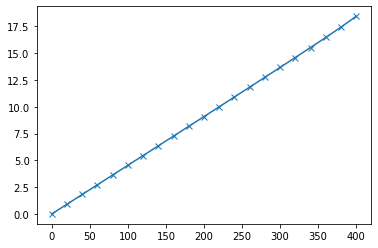

In [8]:
plt.plot(flist, ulist, "-x")

Plot e.g. the plastic strain component $\varepsilon_{p,xx}$

In [9]:
Draw(alpha[0], mesh, "strainp_xx", deformation=u)


WebGuiWidget(value={'gui_settings': {}, 'ngsolve_version': '6.2.2402-40-g3ac4c9abc', 'mesh_dim': 2, 'order2d':…

BaseWebGuiScene

Visualize the plastic zone

In [10]:
Draw(Norm(strain_p(alpha)), mesh, "abs_strainp", deformation=u, autoscale=False, min=0.0, max=0.001)

WebGuiWidget(value={'gui_settings': {}, 'ngsolve_version': '6.2.2402-40-g3ac4c9abc', 'mesh_dim': 2, 'order2d':…

BaseWebGuiScene

### Displacment-controlled simulation
Add a Lagrangian multiplier $f$ which equals the force applied to the right edge, and use it to set the mean $u_x$ displacement along the edge to some increasing value.

In [11]:
fespace_u = VectorH1(mesh, order=order, dirichletx="symx", dirichlety="symy", dirichletz="symz")
fespace_alpha = L2(mesh, order=order-1)**3
fespace_lag = FESpace("number", mesh, definedon=mesh.Boundaries("force"))

fespace = fespace_u * fespace_alpha * fespace_lag

q = GridFunction(fespace)
u, alpha, f = q.components

q0 = GridFunction(fespace)
u0, alpha0, f0 = q0.components


In [12]:
u_, alpha_, f_ = fespace.TrialFunction()
deltau_, deltaalpha_, deltaf_ = fespace.TestFunction()

gradu_ = Sym(Grad(u_))
strain_ = CoefficientFunction((gradu_[0], gradu_[1], 0,
                               gradu_[2], gradu_[3], 0,
                               0, 0, 0), dims=(3,3))


strain_el_ = strain_ - strain_p(alpha_)

psi_el = mu*InnerProduct(strain_el_,strain_el_) + lam/2*Trace(strain_el_)**2

psi_p = mu_H*InnerProduct(strain_p(alpha_), strain_p(alpha_))

strain_p_dot_ = strain_p(alpha_) - strain_p(alpha0)


a = BilinearForm(fespace, eliminate_internal=True)
a += SymbolicEnergy(psi_el + psi_p)
a += SymbolicEnergy( sqrt(2/3)*sigma_Y*NormReg(strain_p_dot_), bonus_intorder=-2)
a += SymbolicEnergy(f_*(loadpar-u_[0]), definedon=mesh.Boundaries("force"))


In [13]:
q.vec[:] = 0
q0.vec[:] = 0

In [14]:
flist = [0]
ulist = [0]
hv = q0.vec.CreateVector()

delta_disp = 0.02
force = 0
ux_mean = 0
while force < 435:
    print(f"load step: ux {ux_mean} -> {ux_mean + delta_disp}:")
    hv.data = q.vec - q0.vec
    q0.vec.data = q.vec
    q.vec.data += hv

    loadpar.Set(ux_mean + delta_disp)
    err, nit = NewtonWithLinesearch(a, q.vec)
    if err: break

    ux_mean += delta_disp
    force = f.vec[0]
    flist.append(force)
    ulist.append(ux_mean)

load step: ux 0 -> 0.02:
initial residual 1.9999999999999944
newton step  1  res  82.02287804260581 damping 1
newton step  2  res  0.01357475950475457 damping 1
newton step  3  res  1.1227166972004377e-07 damping 1
newtonsteps:  3 , res  1.1227166972004377e-07  <  1e-06 * 82.02287804260581
load step: ux 0.02 -> 0.04:
initial residual 21019.147366980662
newton step  1  res  326.82947684873864 damping 1
newton step  2  res  0.47471054414832686 damping 1
newton step  3  res  0.00036234766288895944 damping 1
newtonsteps:  3 , res  0.00036234766288895944  <  1e-06 * 21019.147366980662
load step: ux 0.04 -> 0.06:
initial residual 21010.890458777256
newton step  1  res  579.268166008972 damping 1
newton step  2  res  3.459575912193518 damping 1
newton step  3  res  0.060092464757992445 damping 1
newton step  4  res  3.261954264865662e-05 damping 1
newtonsteps:  4 , res  3.261954264865662e-05  <  1e-06 * 21010.890458777256
load step: ux 0.06 -> 0.08:
initial residual 21002.207516428458
newton 

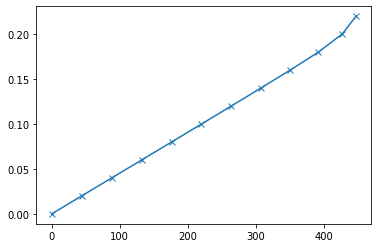

In [15]:
plt.plot(flist, ulist, "-x")

In [16]:
Draw(alpha[0], mesh, "strainp_xx", deformation=u)

WebGuiWidget(value={'gui_settings': {}, 'ngsolve_version': '6.2.2402-40-g3ac4c9abc', 'mesh_dim': 2, 'order2d':…

BaseWebGuiScene

In [97]:
q.vec[:] = 0
q0.vec[:] = 0

flist = [0]
ulist = [0]
hv = q0.vec.CreateVector()

loadsteps = np.concatenate((np.linspace(0,0.3,10,endpoint=False),
                            np.linspace(0.3,-0.3,20,endpoint=False),
                            np.linspace(-0.3,0.3,20,endpoint=False)))

for l in loadsteps:
    print(f"load step: ux {l}:")
    hv.data = q.vec - q0.vec
    q0.vec.data = q.vec
    q.vec.data += hv

    loadpar.Set(l)
    err, nit = NewtonWithLinesearch(a, q.vec)
    if err: break

    force = f.vec[0]
    flist.append(force)
    ulist.append(l)
    

load step: ux 0.0:
initial residual 0.0
load step: ux 0.03:
initial residual 2.999999999999992
newton step  1  res  278.57799186567956 damping 1
newton step  2  res  0.07844827910764715 damping 1
newton step  3  res  5.247870715945238e-07 damping 1
newtonsteps:  3 , res  5.247870715945238e-07  <  1e-06 * 278.57799186567956
load step: ux 0.06:
initial residual 31767.180730826585
newton step  1  res  1106.1213666437782 damping 1
newton step  2  res  2.647048144461298 damping 1
newton step  3  res  0.001791105827874558 damping 1
newtonsteps:  3 , res  0.001791105827874558  <  1e-06 * 31767.180730826585
load step: ux 0.09:
initial residual 31754.263087069143
newton step  1  res  1991.9574831260693 damping 1
newton step  2  res  16.40072290771471 damping 1
newton step  3  res  0.38352562701188503 damping 1
newton step  4  res  0.001580466382390646 damping 1
newtonsteps:  4 , res  0.001580466382390646  <  1e-06 * 31754.263087069143
load step: ux 0.12:
initial residual 31739.728162286647
newt

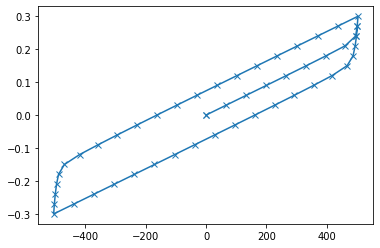

In [98]:
plt.plot(flist, ulist, "-x")